<a href="https://colab.research.google.com/github/allen44/riiid-test-answer-prediction/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

%cd /content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/
%pwd

pwd = Path.cwd()
train_csv_path = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.csv')
train_pkl_path = Path('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.pkl.gzip')

def ms_to_days(array_like):
  return np.divide(array_like, 86400000)

/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction


#Import the data

In [3]:
#Load a DataFrame of train.csv from pikl for better performance on import 
%%time
with open( train_pkl_path, 'rb') as f:
  df = pickle.load(f)




CPU times: user 5.64 s, sys: 13.8 s, total: 19.4 s
Wall time: 1min 1s


In [3]:
# Alternatively, make DataFrame from CSV
%%time
df = pd.read_csv(train_csv_path, index_col='row_id')


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


TypeError: ignored

In [5]:
#After importing as a dataframe, save the dataframe as a binary file, in case the notebook instance crashes, so that we can quickly reload the dataframe and resume.
%%time
df.to_pickle(train_pkl_path)

CPU times: user 7.74 s, sys: 11.7 s, total: 19.5 s
Wall time: 1min 29s


In [4]:
df.head(10)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False
5,157063,115,156,0,5,2,1,5000.0,False
6,176092,115,51,0,6,0,1,17000.0,False
7,194190,115,50,0,7,3,1,17000.0,False
8,212463,115,7896,0,8,2,1,16000.0,False


#Examine the shape of the dataframe, summary statistics, and missing values

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 7.5+ GB


In [17]:
print(f"The shape of this dataframe is {df.shape}.")

The shape of this dataframe is (101230332, 9).


##Check for missing data

In [5]:
# Count missing values
df.isna().sum()

timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

The data is mostly clean, and only two columns have missing data. Based on the discriptions of the data, these columns missing data is intentional.


##Check unique entries and dtypes

In [8]:
#Check the relative frequency of unique values in each column
# Save the values here, to avoid re-computation later
%time
df_nunique = df.nunique()
df_nunique

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


timestamp                         72821015
user_id                             393656
content_id                           13782
content_type_id                          2
task_container_id                    10000
user_answer                              5
answered_correctly                       3
prior_question_elapsed_time           3258
prior_question_had_explanation           2
dtype: int64

In [9]:
nunique_answered_correctly = df_nunique['answered_correctly']
nunique_prior_question_had_explanation = df_nunique['prior_question_had_explanation']

nunique_answered_correctly, nunique_prior_question_had_explanation

(3, 2)

Noteably, the number of unique task_container_id is exactly 10000. 

'answered_correctly' is a boolean except for the NaN entries.



##Set the index

In [10]:
if 'row_id' in df.columns:
  df.set_index('row_id', inplace=True)
df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,True
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


## Changing dtypes
As the number of unique entries in each column is comparatively low, relative to the size of the data set, there will be perfomance gains by recaasting most of these colums as categorical variables.

timestamp and prior_question_elapsed_time            is an exception and should be treated differently.

prior_question_elapsed_time is a float and probably should not be categorical.

prior_question_had_explanation should be change to dtype:bool


In [11]:
#Check dtypes before
df.dtypes

timestamp                            int64
user_id                           category
content_id                        category
content_type_id                   category
task_container_id                 category
user_answer                       category
answered_correctly                category
prior_question_elapsed_time        float64
prior_question_had_explanation        bool
dtype: object

In [12]:
categorical_columns = ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly']
for column_id in categorical_columns:
  df[column_id] = pd.Categorical(df[column_id])

boolean_columns = ['prior_question_had_explanation']
for column_id in boolean_columns:
  df[column_id] = df[column_id].astype(bool)

df.dtypes

timestamp                            int64
user_id                           category
content_id                        category
content_type_id                   category
task_container_id                 category
user_answer                       category
answered_correctly                category
prior_question_elapsed_time        float64
prior_question_had_explanation        bool
dtype: object

Check to make sure the missing data is retained.

#EDA using a subsample
As the Google Colab runtime keeps crashing due to lack of memory (even with Colab Pro), we will switch to importing only about 1% or 10% of the data for this EDA. IF we see that this subset differs signifcant;y fullset's summary statistics, we can contiue to attempt using the full set.

In [13]:
#Define the skip logic

#Skip rows from based on condition like skip every 10th line
def skip_all_but_nth_rows(n, idx):
  return (idx % n != 0)
  
#Skip random lines  
import random
def rand_1_in_n(n, idx):
  return True if random.randrange(1,n)==1 else False


###If subsetting from existing dataframe with all data

In [14]:
#Define a Dataframe with 1/10 of the data
df_1_10 = df[df.index % 10 == 0]

#Define a DataFrame with 1/100 of the data
df_1_100 = df[df.index % 100 == 0]

In [15]:
df_1_10.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,True
10,255381,115,152,0,10,2,0,17000.0,False
20,490100,115,4,0,20,1,0,29000.0,False
30,710402,115,100,0,30,0,1,20000.0,False
40,667971812,115,2065,0,40,2,1,17000.0,False


In [16]:
df_1_100.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,True
100,169080,5382,5965,0,4,2,1,18000.0,False
200,553597450,5382,6078,0,105,0,1,22000.0,True
300,406185018,8623,7934,0,64,3,1,13000.0,True
400,3082978171,12741,4853,0,24,3,1,36000.0,True


# Exploring the data in each column, individually

From the Kaggle website:


row_id: (int64) ID code for the row.

  timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.





##timestamp

>timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

In [34]:
df['timestamp'].describe(include='all')

count    1.012303e+08
mean     7.703644e+09
std      1.159266e+10
min      0.000000e+00
25%      5.243436e+08
50%      2.674234e+09
75%      9.924551e+09
max      8.742577e+10
Name: timestamp, dtype: float64

Converting this from ms to years may be useful.

In [35]:
timestamp_in_days = ms_to_days(df['timestamp'])
timestamp_in_days.describe(include='all')

count    1.012303e+08
mean     8.916254e+01
std      1.341743e+02
min      0.000000e+00
25%      6.068791e+00
50%      3.095178e+01
75%      1.148675e+02
max      1.011872e+03
Name: timestamp, dtype: float64

Text(0.5, 1.0, '')

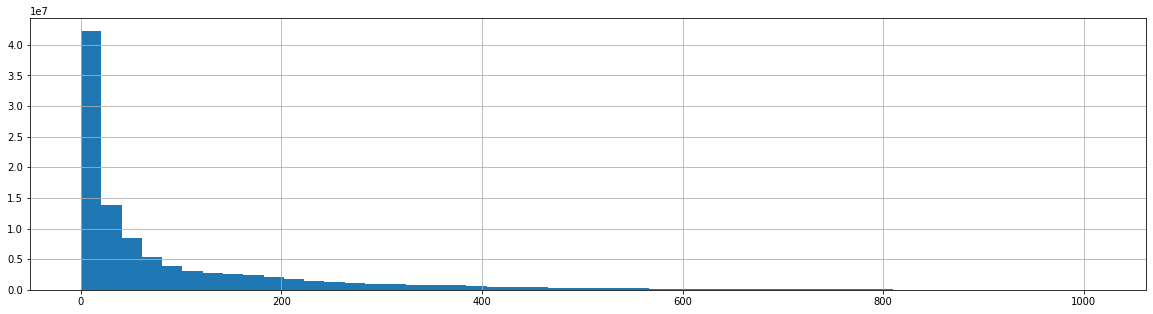

In [38]:
timestamp_in_days.hist(bins=50, figsize=(20, 5))
plt.title('')

Let plot to see the distribution of the data, along with summary statistics.

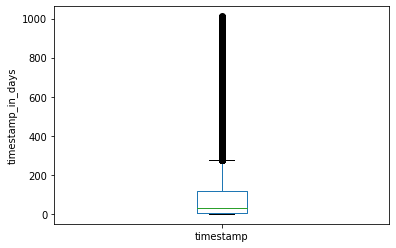

In [39]:
timestamp_in_days.plot(kind='box')
plt.ylabel('timestamp_in_days')
plt.show()

A boxplot would be more informative with a log y-scale

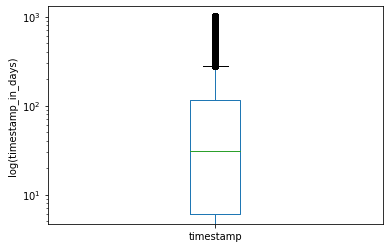

In [40]:
timestamp_in_days.plot(kind='box', logy=True)
plt.ylabel('log(timestamp_in_days)')
plt.show()

A box plot shows that that the timestamps generally have values 6 days and 105 days. 

It would be useful to check later if some users use the platform much more than others.

There is a right-skewness but no reason yet to consider these as outliers to drop or correct.

Most of the data entries were from relatively "young" user accounts, while a minority of data are from older user accounts. The units here are milliseconds since account creations, so the average action took place about 0.23 years after account creation.

##user_id

This is presumed to a unique user id that is randomly distributed to each user, with one per user.

This data can be used to relate data etries from the same users through out the data set.


In [86]:
#Count the unique users in this data set
unique_users = df['user_id'].unique()
unique_users

[115, 124, 2746, 5382, 8623, ..., 2147470770, 2147470777, 2147481750, 2147482216, 2147482888]
Length: 393656
Categories (393656, int64): [115, 124, 2746, 5382, ..., 2147470777, 2147481750, 2147482216,
                             2147482888]

In [82]:
user_id_value_counts = df['user_id'].value_counts()
user_id_value_counts

801103753     17917
1478712595    16914
1842816145    16851
455973631     16789
1660941992    16777
              ...  
1632816630        1
1946651368        1
118250768         1
594429989         1
1610758750        1
Name: user_id, Length: 393656, dtype: int64

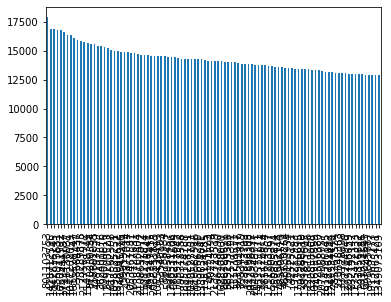

In [104]:
user_id_value_counts[:100].plot(kind='bar')

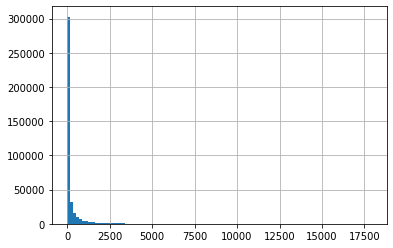

In [96]:
user_id_value_counts.hist(bins=100)

We can see that a small minority of users generate most of the 

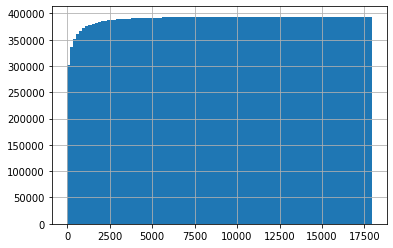

In [102]:
user_id_value_counts.hist(cumulative=True, bins=100)

##content_id

How many different content_id are there? How often does the most common content_ID occur? Does any small group of content_ids form a disproportionate amount of the events?

In [22]:
df_content_id_value_counts = df['content_id'].value_counts()
df_content_id_value_counts.describe()

count     13782.000000
mean       7345.111885
std       11415.012275
min           1.000000
25%        1757.000000
50%        4728.500000
75%        8617.000000
max      213605.000000
Name: content_id, dtype: float64

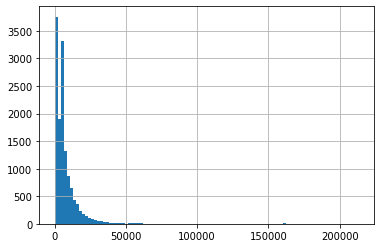

In [23]:
#Count the unique content_ids and describe the distribution of the counts

df_content_id_value_counts.hist(bins=100);

In [ ]:
df_content_id_value_counts.hist(bins=100, normalize

We  13320 unique content ids.

The most common content_id occured only {{{df_content_id_value_counts.max()}}} of the time. The average content_id occurs about 0.007% of the time.

It may be useful to consider these in groups, because any single content_id is such a small part of the whole set.


##content_type_id

>content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.



In [25]:
#Count the unique content_type_ids and describe the distribution of the counts
content_type_id_value_counts = df['content_type_id'].value_counts()
content_type_id_value_counts

0    99271300
1     1959032
Name: content_type_id, dtype: int64

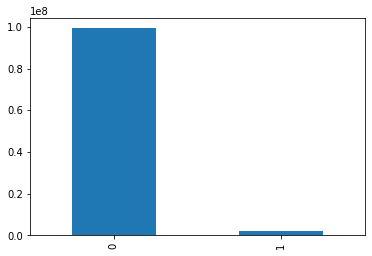

In [26]:
content_type_id_value_counts.plot(kind='bar')

We note that ther are only two content_id_types.


 Most of the data are questions posed to the user.

In [36]:
print(f"{100*content_type_id_value_counts[1]/len(df)}% of the data is the user watching a lecture.")

1.9352223402764301% of the data is the user watching a lecture.


##task_container_id

>task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

In [38]:
#Count the unique task_container_id and describe the distribution of the counts
task_container_id = df['task_container_id']
task_container_id.value_counts()

14      804285
15      798539
4       692079
5       690051
6       688813
         ...  
9927       174
9999       174
9925       172
9937       172
9926       170
Name: task_container_id, Length: 10000, dtype: int64

In [39]:
task_container_id.value_counts(normalize=True)

14      0.007945
15      0.007888
4       0.006837
5       0.006817
6       0.006804
          ...   
9927    0.000002
9999    0.000002
9925    0.000002
9937    0.000002
9926    0.000002
Name: task_container_id, Length: 10000, dtype: float64

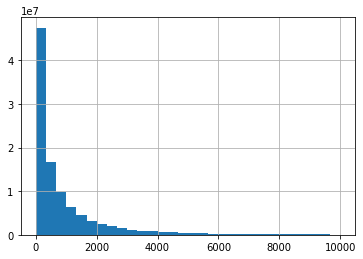

In [49]:
#Count the unique task_container_id and describe the distribution of the counts

task_container_id.hist(bins=30)

Of the 10000 task_container_ids, over 85% have a the data use the task_container_id with id less than 2000.

It's notable that the task_container_ids with the lowest numbers tend to occur most frequently. Perhaps these id were not randomly assigned from a hash but were assigned sequentially.

It could be useful to dig in to the docs and find if certain task_container_ids have further meaning which could be useful in feature engineering.

Many of the highest numbered task_container_id only occur once. It''s possble that these task_container_id are unique to a user.

##user_answer

>user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

In [52]:
#Count the unique task_container_id and describe the distribution of the counts
user_answer_value_counts = df['user_answer'].value_counts()
user_answer_value_counts

0     28186489
1     26990007
3     26084784
2     18010020
-1     1959032
Name: user_answer, dtype: int64

In [53]:
user_answer_value_counts_normalized = df['user_answer'].value_counts(normalize=True)
user_answer_value_counts_normalized

0     0.278439
1     0.266620
3     0.257678
2     0.177911
-1    0.019352
Name: user_answer, dtype: float64

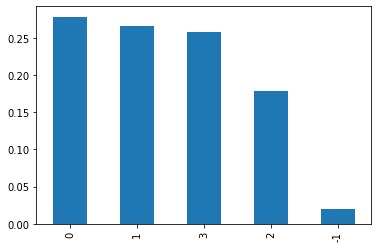

In [57]:
user_answer_value_counts_normalized.plot(kind='bar')

It looks like the these are multiple choice answers. Of the 4 nonlecture types, it looks like there is a negative bias on category 2. That is, users answer '2' less often then expected from chance alone. It could be that the users are inherently biased aginast answering with  '2', or possibly, the questions creators are have biased questions so that users are less likely to select '2', or it could be something else. 

We may have to transform this column later so that the '-1' values are not in this coloumn, depending on the requirements of the pipelines we use later. An easy transform might be to asssign NaN to these '-1' values.

##answered_correctly (Target variable)

`answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.`

In [58]:
#Count the unique task_container_id and describe the distribution of the counts
df['answered_correctly'].value_counts()

1     65244627
0     34026673
-1     1959032
Name: answered_correctly, dtype: int64

In [59]:
#Check the frequency of each count
df['answered_correctly'].value_counts(normalize=True)

1     0.644517
0     0.336131
-1    0.019352
Name: answered_correctly, dtype: float64

The '-1' occurs here exactly as frequent as in user_answer. It might be best to seperate the lecture rows entirtely from the rest of the dataframe, rather than transform it.

##prior_question_elapsed_time

`prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.`

It might be possible to determine each user's first lecture from this point alone.
 

In [60]:
#Count the unique prior_question_elapsed_time and describe the distribution of the counts
prior_question_elapsed_time = df['prior_question_elapsed_time']
prior_question_elapsed_time.value_counts()

17000.0     5154588
16000.0     4752104
18000.0     4670915
19000.0     4017031
15000.0     3640279
             ...   
252800.0          1
251200.0          1
297200.0          1
297600.0          1
270333.0          1
Name: prior_question_elapsed_time, Length: 3258, dtype: int64

In [61]:
#Check the frequency of each count
prior_question_elapsed_time.value_counts(normalize=True)


17000.0     5.213037e-02
16000.0     4.805989e-02
18000.0     4.723879e-02
19000.0     4.062581e-02
15000.0     3.681557e-02
                ...     
252800.0    1.011339e-08
251200.0    1.011339e-08
297200.0    1.011339e-08
297600.0    1.011339e-08
270333.0    1.011339e-08
Name: prior_question_elapsed_time, Length: 3258, dtype: float64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


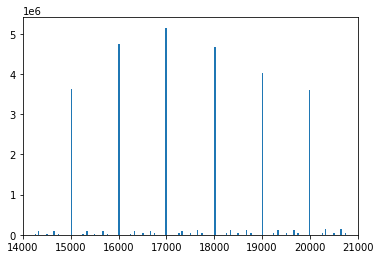

In [62]:

plt.hist(prior_question_elapsed_time, bins=10000)
plt.xlim((14000, 21000))
plt.show()


Well, this looks peculiar. The top 5 value counts are 17.000 seconds, 16.000 seconds, 18.000 seconds, 19.000 seconds, and 15.000. The units is milliseconds, but these top five values appear to either have been rounded to the nearest second, or the students are machinely-like in their precision of submitting the answer on the exact milliseconds so that the delay is multiple of 1000 millisenconds. 

Alternatively, an automated tool, like a test-taking bot--designed to harvest test questions by guessing any answer while scraping the question content to store in a database for use later--has been answering questions with a simulated delay that can be modeled by a discrete normal distribution with mean 17000. The magnitude of this hypoithesized automnation is such that around 20% of all answers submitted could fit this model.

Cross-referencing user_ids connected to these anomolus prior_question_elapsed_time values could lend support to the hypothesis if there are a small number of user ids who make a disprotionate amount of all answers.

If the hypothesis is true,
It may be useful later to feature-engineer these automated users (bots) into their own column or dataframe, as their behavior could be quite different from the human users. It may be easier to model the responses of the bots seperately from the humans.

An alternative explanation could be that, assuming this educational platform is accessed via a web browser, some web browsers may round times  to whole-number of seconds. It unlikely though. Also, this fails to address the simulated discrete normal distribution about 17.000 seconds.

Let's continue without seperating the two populations for now...

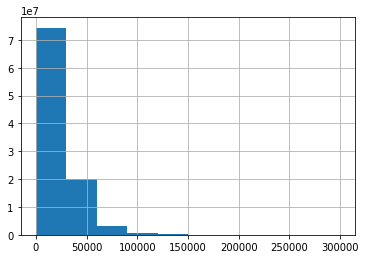

In [63]:
prior_question_elapsed_time.hist()

In [64]:
prior_question_elapsed_time.describe()

count    9.887879e+07
mean     2.542381e+04
std      1.994815e+04
min      0.000000e+00
25%      1.600000e+04
50%      2.100000e+04
75%      2.966600e+04
max      3.000000e+05
Name: prior_question_elapsed_time, dtype: float64

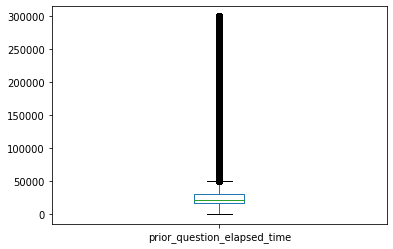

In [65]:
prior_question_elapsed_time.plot(kind='box')

Using a log scale on the y-axis for clarity:

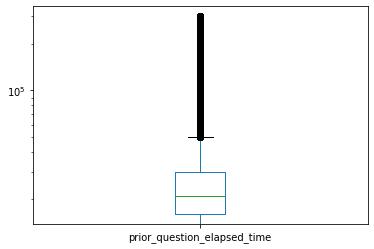

In [66]:
prior_question_elapsed_time.plot(kind='box', logy=True)

Mean time to answer the last question is about 25 seconds; the median is 21.000 seconds.

The effect of the hypothesized bot subpopulation is large enough that it is convolutes our summary statistics on the whole population. We see that the 25th-percentile and median are 16.000 seconds and 21.000 seconds. 

It looks like there a hard cutoff on answer times at 5 minutes (300000 milliseconds).

We might have to discard answers given with delay 0, as I don't know what they mean yet.


##prior_question_had_explanation

`prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.`





In [67]:
prior_question_had_explanation = df['prior_question_had_explanation']

In [68]:
prior_question_had_explanation.value_counts()

True     90078066
False    11152266
Name: prior_question_had_explanation, dtype: int64

I'm not quite sure what this means here. I might have to read the documentation more to learn about what the nearly 90% fraction of prioor questions that had an explanation after.

#Exploring the data in each column vs the target variable.

In [69]:
target_var_str = 'answered_correctly'

##Scatterplots of the features vs the target variable

In [74]:
# define useful function to create scatterplots of target variable against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8), data=df, alpha=0.1):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y =target_var_str, data=data, alpha=alpha)
        ax.set(xlabel=col, ylabel=target_var_str)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [71]:
#Create a list of features
features = [feature for feature in df.columns if feature not in [target_var_str]]

CPU times: user 2.12 s, sys: 130 ms, total: 2.25 s
Wall time: 2.26 s


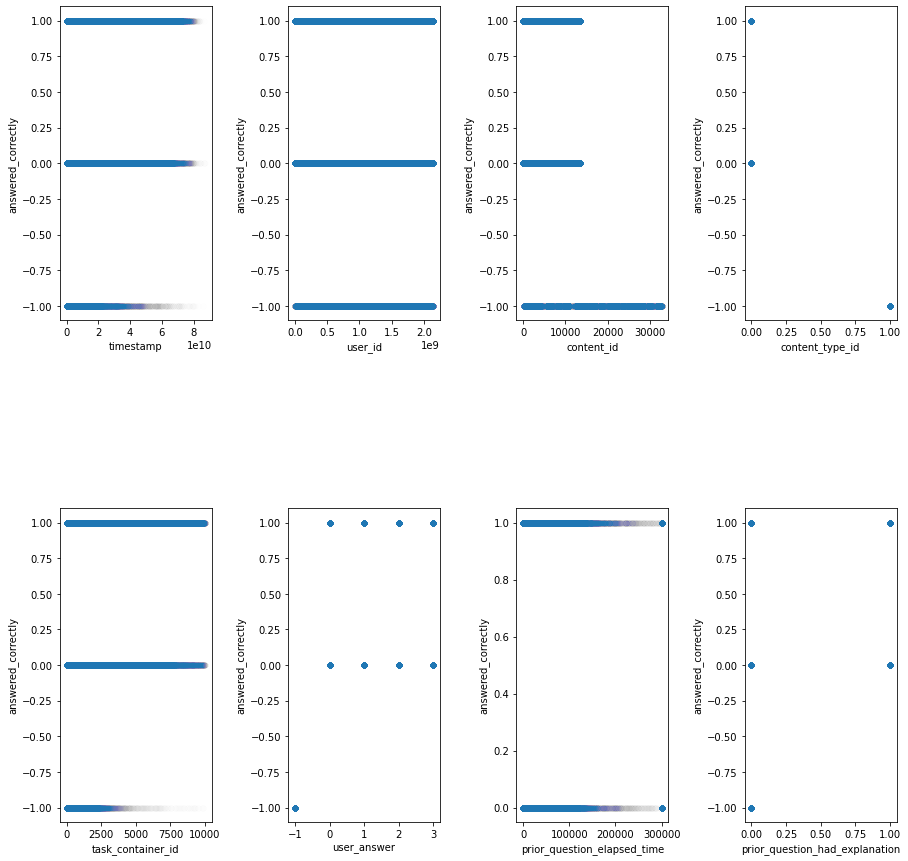

In [77]:
#Use the 1/100 sized dataframe here
%%time
scatterplots(features, ncol=4, figsize=(15, 15), data=df_1_100, alpha=0.005)


The scatter plots don't show any linear correlation with the target variable.

We can see that it the higher-numbered content_id don't have any non-'-1' entries. We can guess that these higher niumber content_ids are lecture videos where no questions is presented to the student to answer.


In [ ]:
df_1 = df.groupby(['content_id' ])[['answered_correctly']].mean()
# ax = df_1['content_id'].hist()
df_1

DataError: ignored

In [ ]:
df.head()

,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,
13134,15092493419,2183,0,298,1,1,31666.0,True
24418,1622998333,316,0,111,1,1,18000.0,True
24418,4746279837,4005,0,999,3,1,25000.0,True
24418,5617471031,9371,0,1746,2,1,12500.0,True
24418,7056474056,1582,0,2447,3,0,27333.0,True


In [ ]:
df.shape

(101230, 8)

##user_id vs target variable

Are some users_id or groups of user_ids more likely to answer correctly than others?

###user_id grouped by account age

Do older user accounts have a higher rate of answering correctly?

In [80]:
# We can group the users by account age by finding the answer for each user with the largest stamp. 
user_id_timestamp_max = df[df['user_id'] == df.groupby('user_id')]

ValueError: ignored

###user_id grouped by number of entries

In [ ]:
#Count entries by each user
df_user_id = pd.DataFrame(df['user_id'].astype(str))

In [130]:
#Divide into 10 quantiles
user_id_number_of_entries_quantile = pd.qcut(df['user_id'].value_counts(), 9, labels=range(9))
user_id_number_of_entries_quantile.head()

801103753     8
1478712595    8
1842816145    8
455973631     8
1660941992    8
Name: user_id, dtype: category
Categories (9, int64): [0 < 1 < 2 < 3 ... 5 < 6 < 7 < 8]

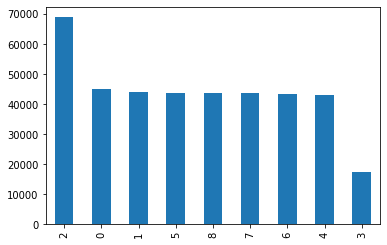

In [131]:
user_id_number_of_entries_quantile.value_counts().plot(kind='bar')